In [2]:
import pandas as pd
import numpy as np
import mne
from matplotlib import pyplot as plt

In [3]:
all_data = pd.read_csv("../Data/Train_and_Validate_EEG.csv", index_col=0).drop("Unnamed: 122",axis=1)
data = all_data.drop(['sex','eeg.date','education','specific.disorder'], axis=1).dropna(axis=0)
data

age     IQ                       main.disorder  AB.A.delta.a.FP1  \
ID                                                                        
1    31.55  103.0                       Mood disorder         48.843890   
2    25.00  115.0                     Healthy control         34.108015   
3    26.20   83.0                       Schizophrenia         31.084064   
5    28.15  101.0                     Healthy control         21.763093   
6    24.00   78.0                  Addictive disorder         20.195088   
..     ...    ...                                 ...               ...   
941  19.23   79.0                       Schizophrenia         22.432700   
942  37.14   97.0  Trauma and stress related disorder         12.887332   
943  20.08   93.0                       Mood disorder         20.055370   
944  33.50  103.0                       Mood disorder         26.430570   
945  40.28  102.0  Trauma and stress related disorder         14.644940   

     AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  AB.A.delta.e.Fz  \
ID                                                                         
1           46.533704        25.924618        30.221841        32.925321   
2           22.838567        20.646824        18.203362        17.361846   
3           28.212342        30.467865        48.643000        28.101162   
5           23.938428        19.517805        24.859077        24.922886   
6           21.631391         9.828767        13.322718        17.876109   
..                ...              ...              ...              ...   
941         22.799740        16.881976        17.067949        20.126371   
942         14.295926        13.959261        24.067048        21.583108   
943         11.734445        15.719485        11.606580        14.575470   
944         20.721589        25.486586        23.016673        23.685829   
945         14.570681        13.731359        10.879896        16.938186   

     AB.A.delta.f.F4  AB.A.delta.g.F8  ...  COH.F.gamma.o.Pz.p.P4  \
ID                                     ...                          
1          37.285136        24.448520  ...              84.825697   
2          16.311194        23.092874  ...              77.398455   
3          39.882668        25.202585  ...              91.510025   
5          22.290161        19.428280  ...              38.160508   
6          13.346347         7.466575  ...              79.562306   
..               ...              ...  ...                    ...   
941        19.186354        17.597424  ...              70.625220   
942        21.555084        11.928572  ...              80.159305   
943        10.810190         5.809250  ...              84.826939   
944        27.051576        25.842116  ...              58.693931   
945        18.366489        18.834494  ...              67.020536   

     COH.F.gamma.o.Pz.q.T6  COH.F.gamma.o.Pz.r.O1  COH.F.gamma.o.Pz.s.O2  \
ID                                                                         
1                62.094883              49.639937              61.347225   
2                48.282117              73.185133              66.742485   
3                51.974239              62.571143              75.509166   
5                21.319727              32.967416              33.401386   
6                34.317402              36.764725              42.045754   
..                     ...                    ...                    ...   
941              59.330855              56.657348              61.684146   
942              34.496443              45.412377              49.901553   
943              64.134452              75.336179              76.576526   
944              40.321880              42.252775              43.764353   
945              49.121421              46.840203              49.256592   

     COH.F.gamma.p.P4.q.T6  COH.F.gamma.p.P4.r.O1  COH.F.gamma.p.P4.s.O2  \
ID                                                                         
1  

In [4]:
bands = ['gamma', 'highbeta', 'beta', 'alpha', 'theta', 'delta']
AB_per_band = {}
AB_cols = []
COH_per_band = {}
COH_cols = []

for band in bands:
    AB_per_band[band] = []
    COH_per_band[band] = []

for col_name in data.columns:
    col_split = col_name.split('.')
    if col_split[0] == 'AB':
        AB_per_band[col_split[2]].append(col_name)
        AB_cols.append(col_name)
    elif col_split[0] == 'COH':
        COH_per_band[col_split[2]].append(col_name)
        COH_cols.append(col_name)

In [5]:
electrodes = set()
for col in COH_cols:
    col_split = col.split('.')
    electrodes.add(col_split[3]+'.'+col_split[4])
    electrodes.add(col_split[5]+'.'+col_split[6])

electrodes = list(electrodes)
electrodes.sort()

len(electrodes)

19

In [6]:
ten_twenty_channels = []
for elec in electrodes:
    split = elec.split('.')
    if split[1] in ('FP1'):
        ten_twenty_channels.append('Fp1')
    elif split[1] in ('FP2'):
        ten_twenty_channels.append('Fp2')
    else:
        ten_twenty_channels.append(split[1])
ten_twenty_channels

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'T3',
 'C3',
 'Cz',
 'C4',
 'T4',
 'T5',
 'P3',
 'Pz',
 'P4',
 'T6',
 'O1',
 'O2']

In [7]:
disorder_label_map = {'Addictive disorder':'Addictive','Anxiety disorder':'Anxiety',
                      'Healthy control':'Control', 'Mood disorder':'Mood', 'Obsessive compulsive disorder':'OCD',
                      'Schizophrenia':'Schizophrenia','Trauma and stress related disorder':'Trauma'}

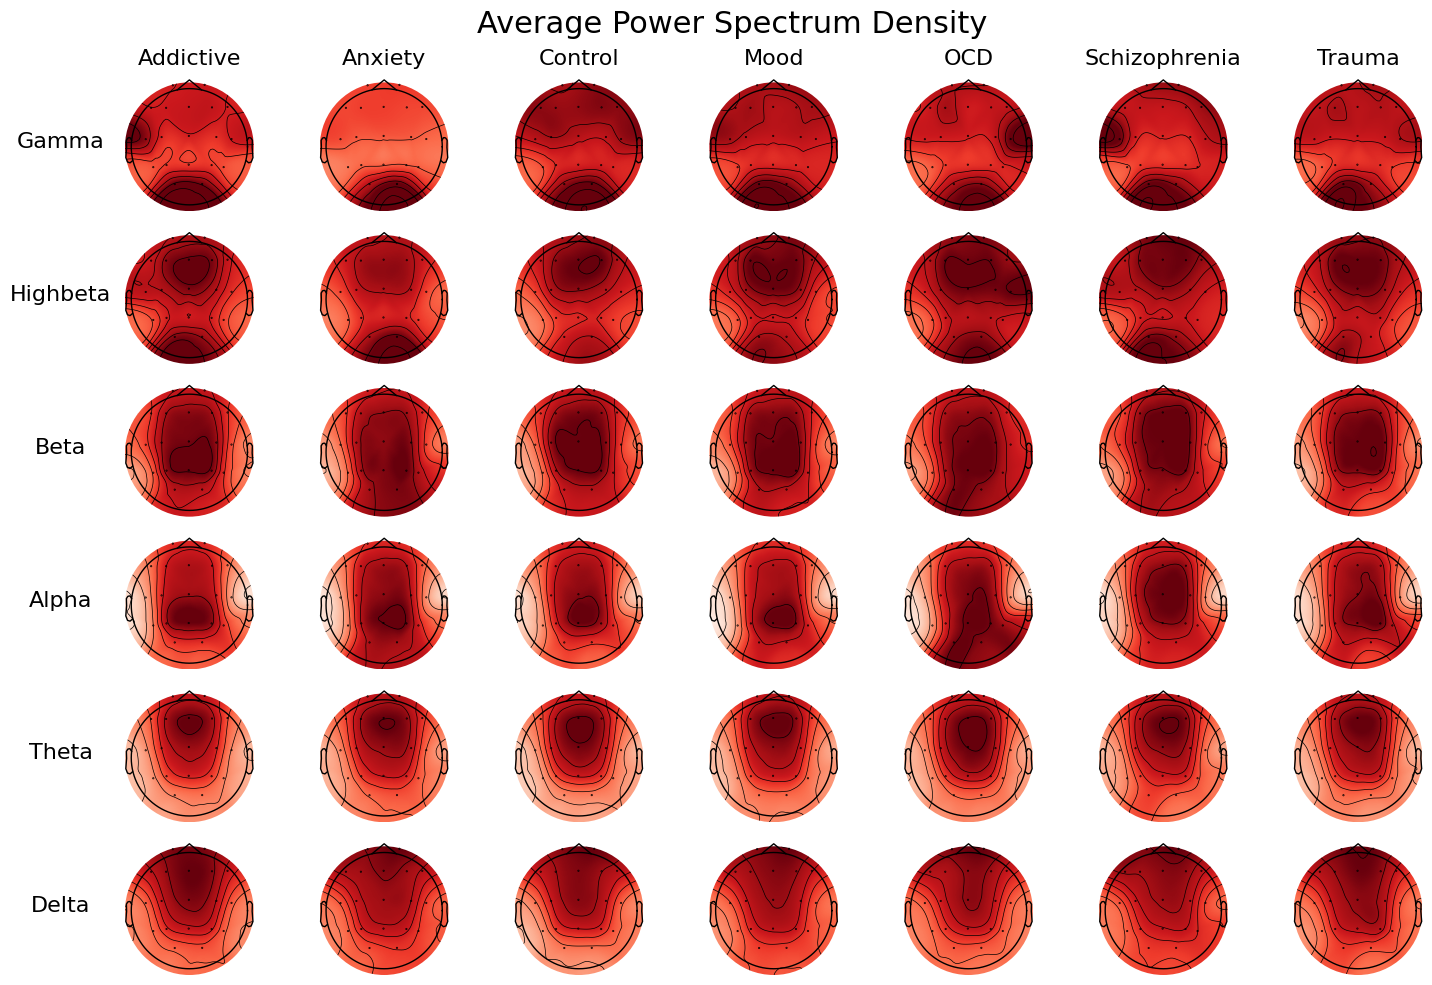

In [ ]:
fig, axes = plt.subplots(6, 7, figsize=(15, 10))
fig.suptitle('Average Power Spectrum Density', fontsize=22)

for b in range(len(bands)):
    band = bands[b]
    axes[b,0].annotate(band.title(),xy=(-0.5, 0.5), xycoords="axes fraction", 
                fontsize=16, ha="center", va="center")

    # vmin, vmax = np.min(data[AB_per_band[band]]), np.max(data[AB_per_band[band]])
    subset = data[AB_per_band[band]].merge(data['main.disorder'], left_index=True,right_index=True)
    subset = subset.set_axis(ten_twenty_channels+['main.disorder'], axis=1).groupby('main.disorder').mean()

    for i in range(subset.shape[0]):
        axes[0,i].set_title(disorder_label_map[subset.index[i]], fontsize=16)
        montage = mne.channels.make_standard_montage('standard_1020')

        # Create an MNE info object for the 19 channels
        info = mne.create_info(ten_twenty_channels, sfreq=100, ch_types="eeg")
        evoked = mne.EvokedArray(np.array(subset.iloc[i,:])[:, np.newaxis], info)
        evoked.set_montage(montage)

        # Plot the PSD topomap
        im, _ = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=axes[b,i], show=False)

plt.tight_layout()

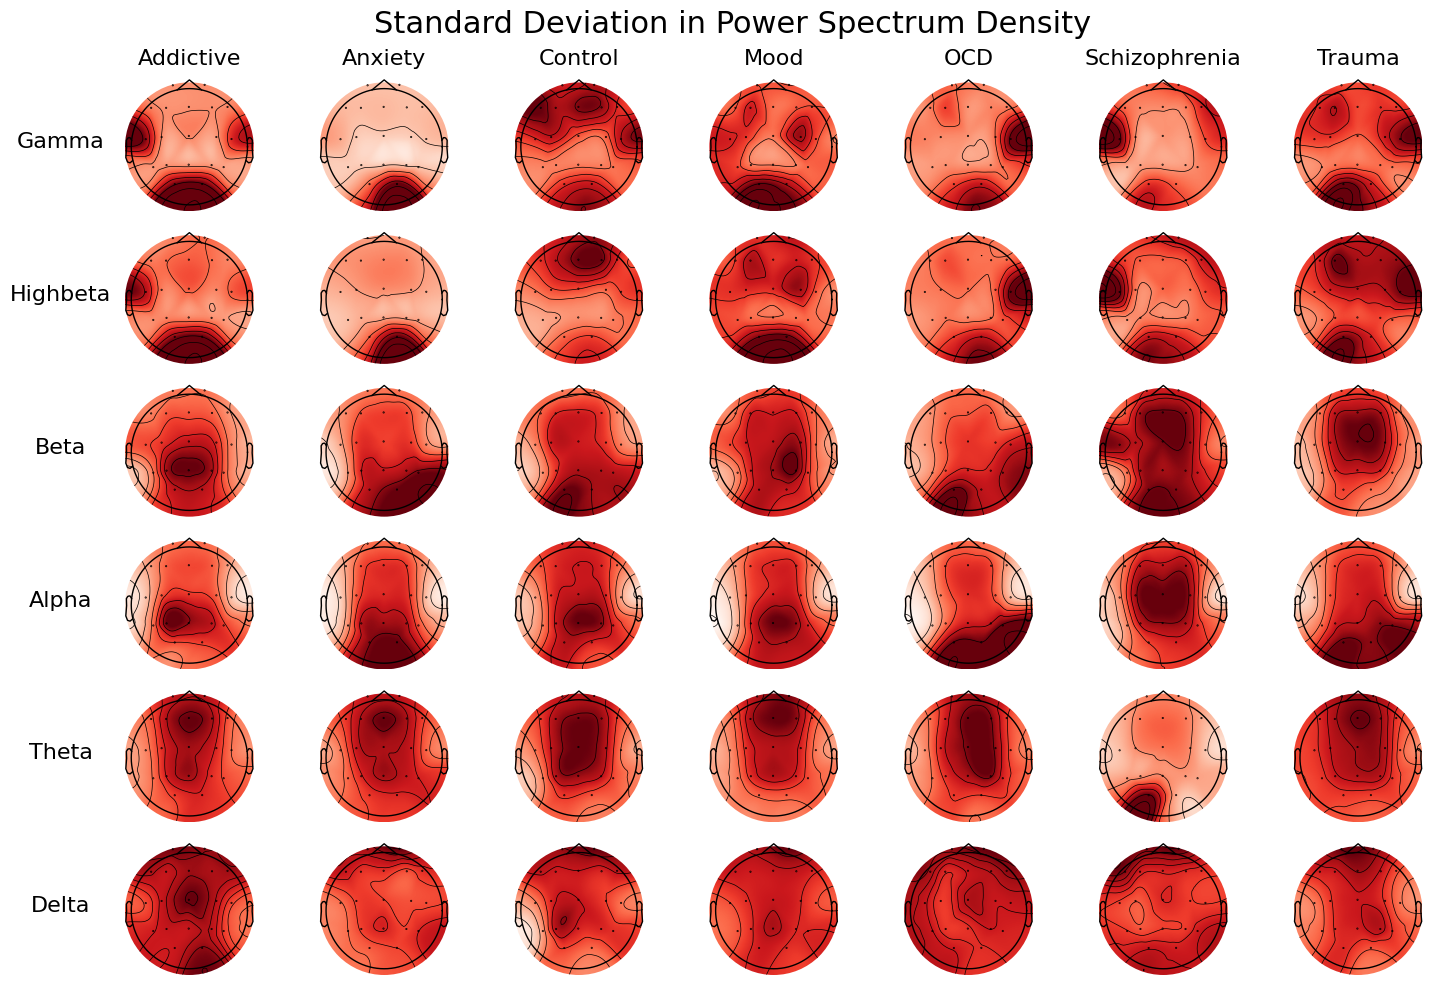

In [10]:
fig, axes = plt.subplots(6, 7, figsize=(15, 10))
fig.suptitle('Standard Deviation in Power Spectrum Density', fontsize=22)

for b in range(len(bands)):
    band = bands[b]
    axes[b,0].annotate(band.title(),xy=(-0.5, 0.5), xycoords="axes fraction", 
                fontsize=16, ha="center", va="center")

    subset = data[AB_per_band[band]].merge(data['main.disorder'], left_index=True,right_index=True)
    subset = subset.set_axis(ten_twenty_channels+['main.disorder'], axis=1).groupby('main.disorder').std()

    for i in range(subset.shape[0]):
        axes[0,i].set_title(disorder_label_map[subset.index[i]], fontsize=16)
        montage = mne.channels.make_standard_montage('standard_1020')

        # Create an MNE info object for the 19 channels
        info = mne.create_info(ten_twenty_channels, sfreq=100, ch_types="eeg")
        evoked = mne.EvokedArray(np.array(subset.iloc[i,:])[:, np.newaxis], info)
        evoked.set_montage(montage)

        # Plot the PSD topomap
        im, _ = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=axes[b,i], show=False)

plt.tight_layout()

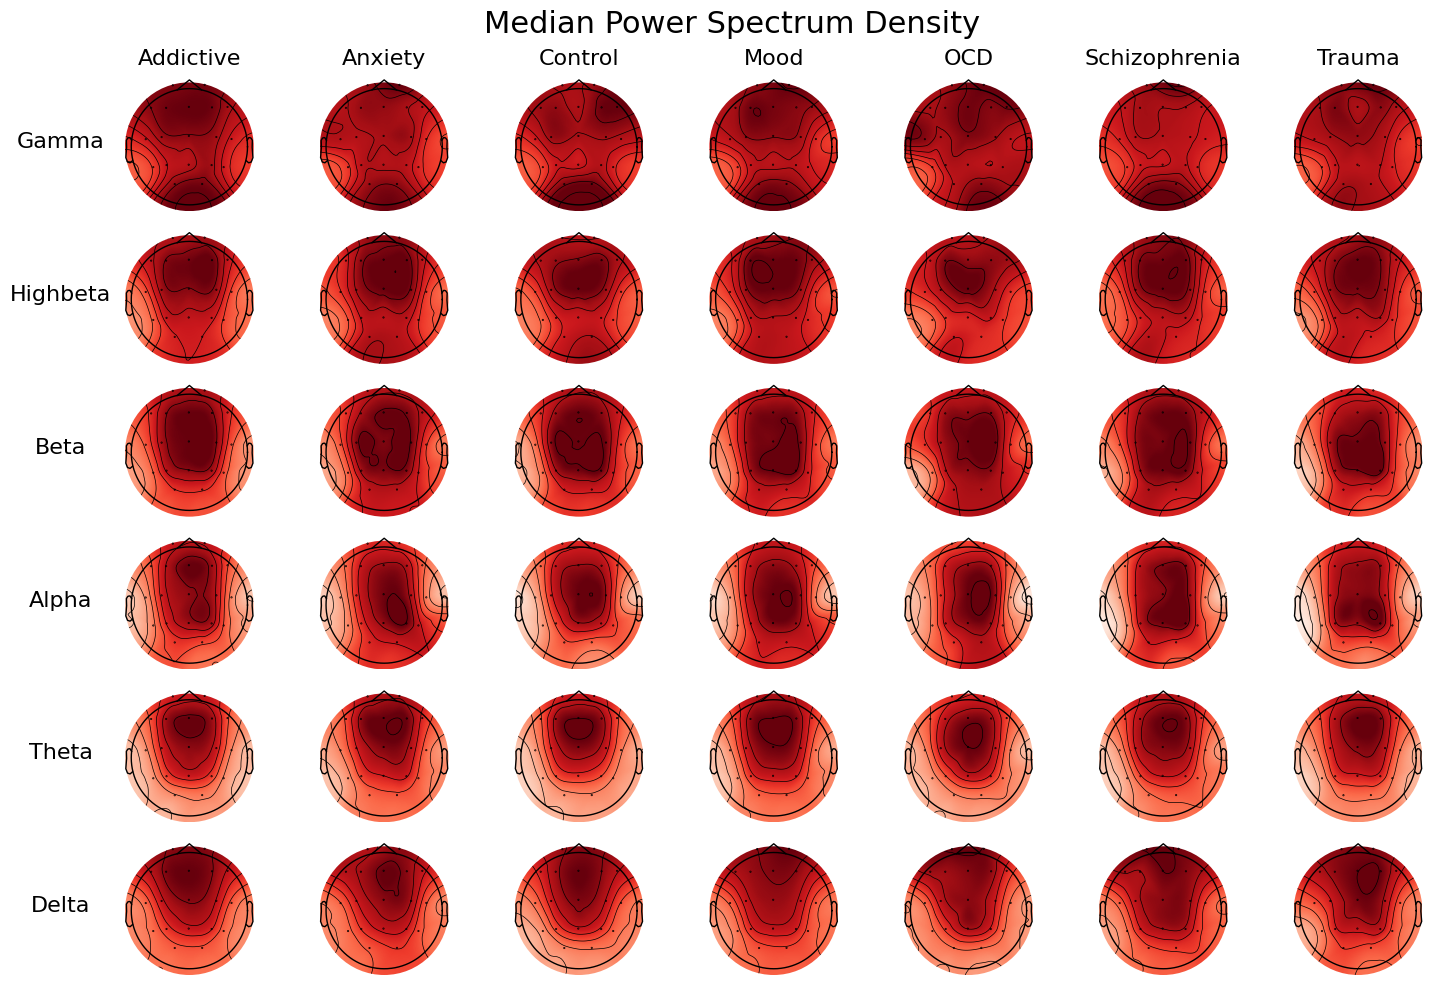

In [12]:
fig, axes = plt.subplots(6, 7, figsize=(15, 10))
fig.suptitle('Median Power Spectrum Density', fontsize=22)

for b in range(len(bands)):
    band = bands[b]
    axes[b,0].annotate(band.title(),xy=(-0.5, 0.5), xycoords="axes fraction", 
                fontsize=16, ha="center", va="center")

    subset = data[AB_per_band[band]].merge(data['main.disorder'], left_index=True,right_index=True)
    subset = subset.set_axis(ten_twenty_channels+['main.disorder'], axis=1).groupby('main.disorder').median()
    # print(band)
    for i in range(subset.shape[0]):
        axes[0,i].set_title(disorder_label_map[subset.index[i]], fontsize=16)
        montage = mne.channels.make_standard_montage('standard_1020')

        # Create an MNE info object for the 19 channels
        info = mne.create_info(ten_twenty_channels, sfreq=100, ch_types="eeg")
        evoked = mne.EvokedArray(np.array(subset.iloc[i,:])[:, np.newaxis], info)
        evoked.set_montage(montage)

        # Plot the PSD topomap
        im, _ = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=axes[b,i], show=False)

plt.tight_layout()

In [14]:
# Look at a random sample
sample = data.sample(100).drop_duplicates('main.disorder')

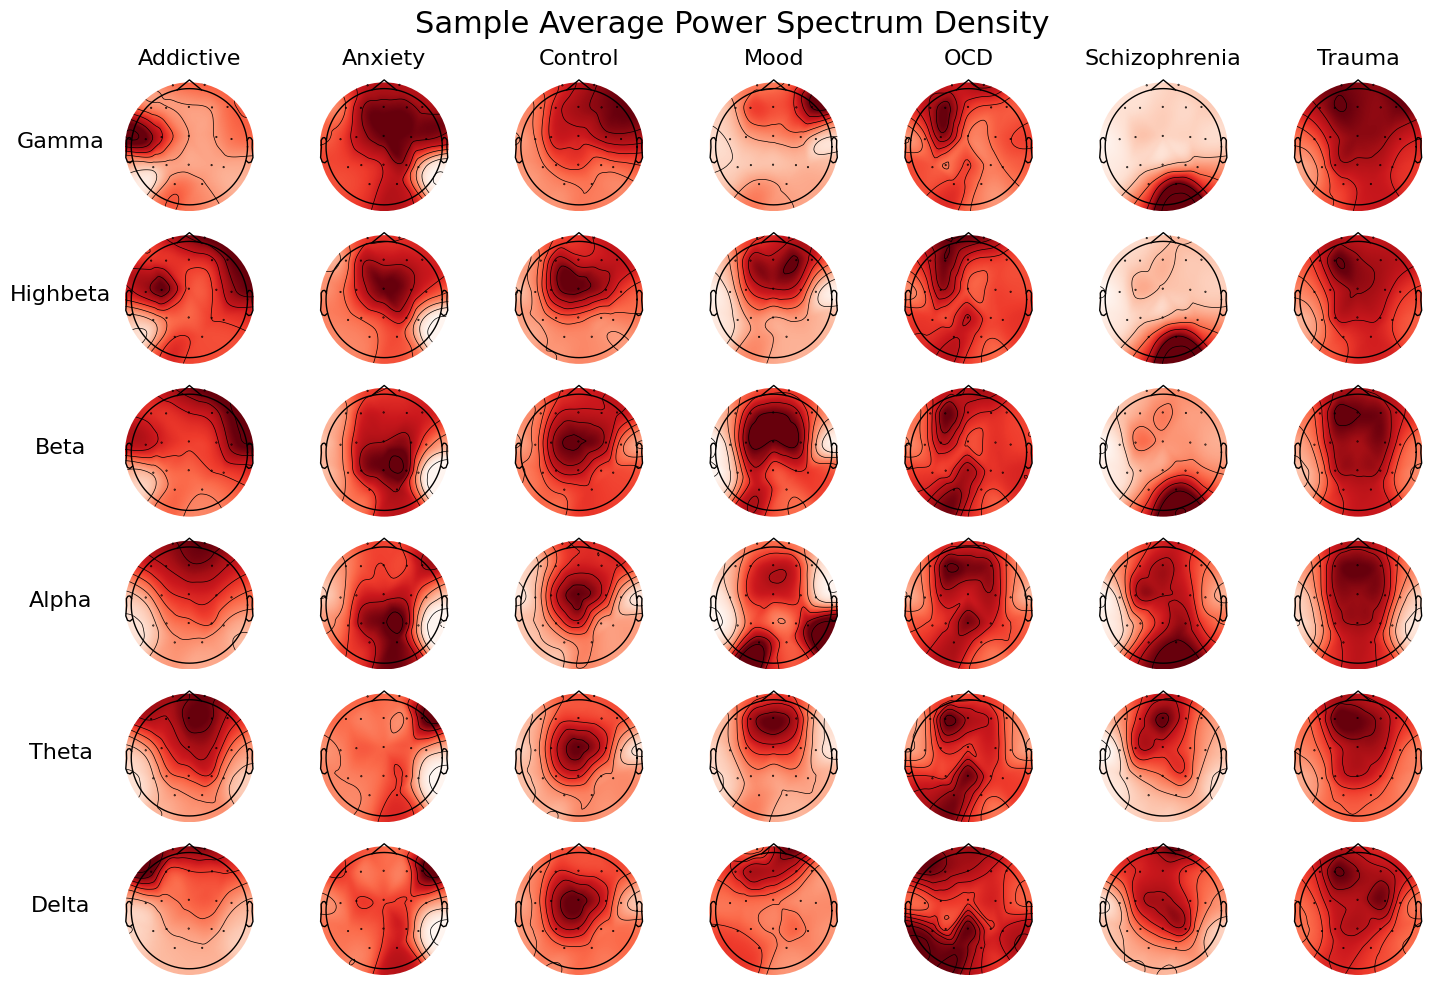

In [16]:
fig, axes = plt.subplots(6, 7, figsize=(15, 10))
fig.suptitle('Sample Average Power Spectrum Density', fontsize=22)

for b in range(len(bands)):
    band = bands[b]
    axes[b,0].annotate(band.title(),xy=(-0.5, 0.5), xycoords="axes fraction", 
                fontsize=16, ha="center", va="center")

    subset = sample[AB_per_band[band]].merge(data['main.disorder'], left_index=True,right_index=True)
    subset = subset.set_axis(ten_twenty_channels+['main.disorder'], axis=1).groupby('main.disorder').mean()
    for i in range(subset.shape[0]):
        axes[0,i].set_title(disorder_label_map[subset.index[i]], fontsize=16)
        montage = mne.channels.make_standard_montage('standard_1020')

        # Create an MNE info object for the 19 channels
        info = mne.create_info(ten_twenty_channels, sfreq=100, ch_types="eeg")
        evoked = mne.EvokedArray(np.array(subset.iloc[i,:])[:, np.newaxis], info)
        evoked.set_montage(montage)

        # Plot the PSD topomap
        im, _ = mne.viz.plot_topomap(evoked.data[:, 0], evoked.info, axes=axes[b,i], show=False)

plt.tight_layout()